<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Selection-bias-lab-experiments" data-toc-modified-id="Selection-bias-lab-experiments-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Selection bias lab experiments</a></span><ul class="toc-item"><li><span><a href="#Response-distributions" data-toc-modified-id="Response-distributions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Response distributions</a></span></li></ul></li></ul></div>

## Lab Experiment Demographics
From the on-line sample of 81 Berlin participants we sent two emails:
1. Email with general inquiry, listing how long the session will be (2 hrs) and how much will they be paid (25-31 eur)
2. If they successfully answered to the first one another email was sent with details of the study (electrical shocks)

In [1]:
import pandas as pd
import ptitprince as pt
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp

In [2]:
from scipy import stats

In [3]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['patch.force_edgecolor'] = True

In [4]:
os.chdir("../../")

In [5]:
# Checks current directory
cwd = os.getcwd() 
print("Current working directory is:", cwd) 

Current working directory is: /data/drive/postdoc/Project4_covid


In [6]:
## Load email response data 
em_data = pd.read_csv('data/email_response_data.csv')
em_data = em_data.set_index('subID', drop=False)

## Load status and the date of participation
status = pd.read_csv('data/task_data/visit1/status_date.csv')
status = status.set_index('subID')
em_data = em_data.join(status)


## Load lab ID and prolific ID link db
link_db = pd.read_csv('data/berlin_lab_participants.csv')
link_db = link_db.loc[:,link_db.columns.intersection(['ID', 'subID'])]
link_db = link_db.set_index('subID')

## Load pooled anxiety data 
an_data = pd.read_csv('output/questionnaires/pooled_anxiety.csv')
an_data.index = an_data.pid

## Load covid-related responses from session 12
s12_data = pd.read_csv('data/session15/clean_dataset_reduced.csv')
s12_data.index = s12_data.PROLIFICID
s12_data = s12_data.loc[s12_data.GROUP=='BE',:]


#### merge data to one data set 
data = em_data.join(link_db).set_index('ID',drop=False)
data = data.join(an_data).join(s12_data)

## adjust data 
data.email2= data.email2.replace({8:0})
data.email2= data.email2.replace({0:"No", 1: "Yes"})
data.email1= data.email1.replace({2:0})
data.email1= data.email1.replace({0: "No", 1: "Yes"})

data.to_csv('output/selection_bias_data.csv')

FileNotFoundError: [Errno 2] File data/task_data/visit1/status_date.csv does not exist: 'data/task_data/visit1/status_date.csv'

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81 entries, 5e99fbca965d4307124a67a5 to 5ea9bb87b6145a0edc839cc2
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subID                 81 non-null     object 
 1   email1                81 non-null     object 
 2   email1_date           44 non-null     object 
 3   email2                44 non-null     object 
 4   email2_date           29 non-null     object 
 5   status                81 non-null     object 
 6   participation_date    51 non-null     object 
 7   ID                    81 non-null     object 
 8   Unnamed: 0            81 non-null     object 
 9   ta_s1                 81 non-null     int64  
 10  ta_s8                 79 non-null     float64
 11  ta_overall            81 non-null     float64
 12  stta_s1               81 non-null     int64  
 13  stta_s8               79 non-null     float64
 14  stta_overall          81 non-null   

### Age and Gender 

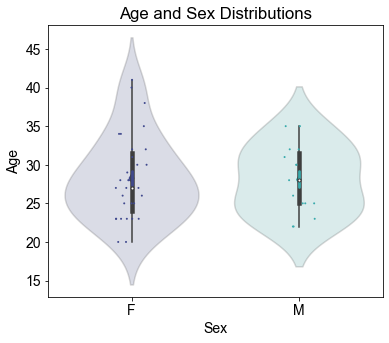

In [9]:
mpl.rcParams['figure.figsize'] = 6,5
mpl.rcParams['font.size'] = 14

sns.violinplot(x = 'sr_gender', y = 'sr_age', data = data, palette = 'mako')
sns.set_style("darkgrid")
g = sns.stripplot(x = 'sr_gender', y = 'sr_age', data = data, palette = 'mako', size = 2, jitter = True )
ax=sns.pointplot(x='sr_gender', y="sr_age", data=data, dodge=.532, join=False, palette='mako', markers="d", scale=.75, ci=68, alpha = [0.1, 0.3]);
for violin, alpha in zip(ax.collections[::2], [0.2,0.2]):
    violin.set_alpha(alpha)
    
# replace labels
plt.ylabel("Age");
plt.xlabel("Sex");

# set title 
ttl = ax.set_title("Age and Sex Distributions", fontsize = "large")
ttl.set_position([.5, 1.05])

### STAI trait/state  distributions and correlation

#### Overall distribution

STAI trait anxiety
STAI state anxiety
STICSA trait anxiety
STICSA state anxiety
BDI
Catastophizing


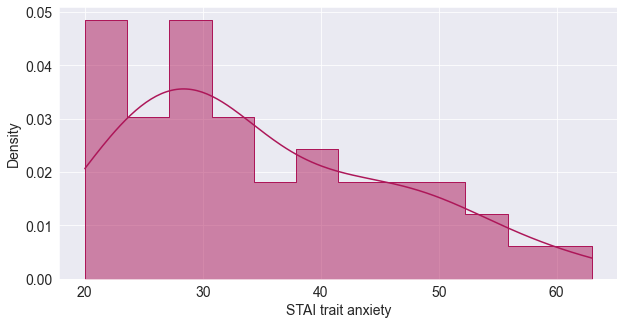

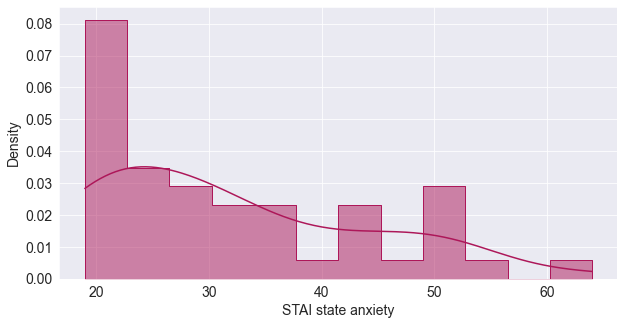

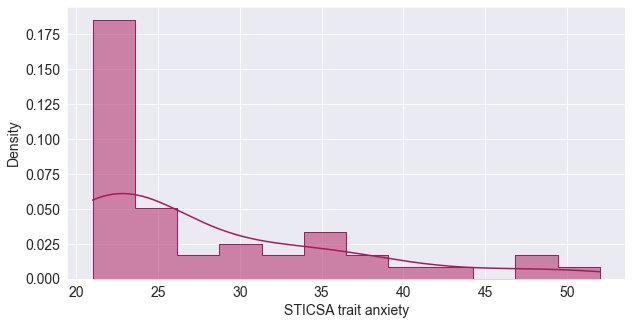

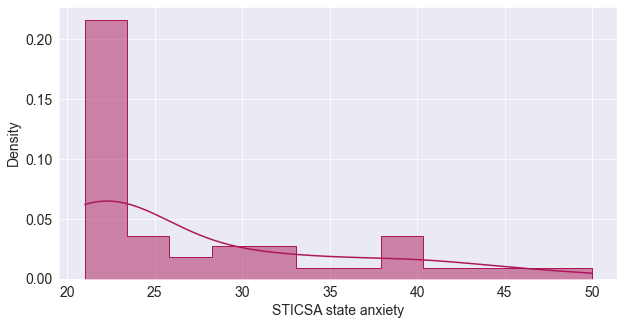

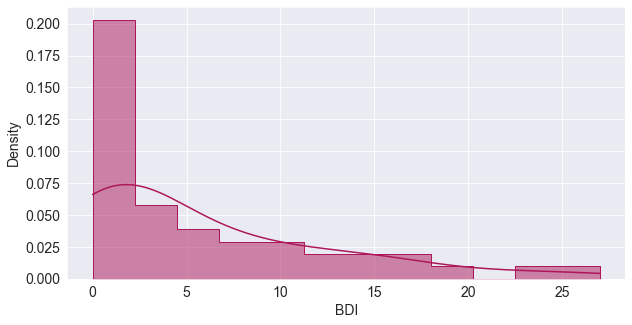

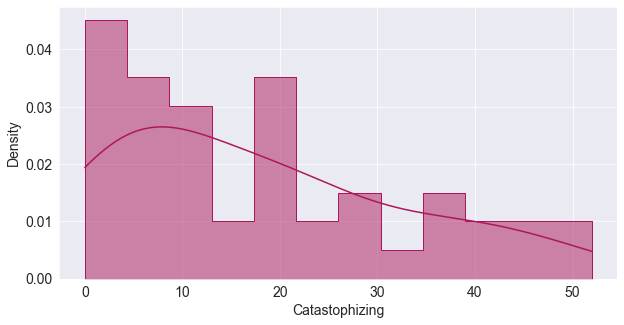

In [10]:
ivs = ["stai_ta", "stai_sa", "sticsa_ta", "sticsa_sa", "bdi", "cat"]; 
#ivs = ['ta_overall']
labels = ['STAI trait anxiety', 'STAI state anxiety', 'STICSA trait anxiety', 'STICSA state anxiety', 'BDI', 'Catastophizing']

for (v,l) in zip(ivs, labels):
    print(l)
    fig, axs = plt.subplots(ncols=1, figsize=(10,5))
    sns.histplot(data=data, x=v, bins=12, stat='density', kde=True, element="step",
                color=sns.color_palette("rocket")[2])
    axs.set_xlabel(l)

#### Cross correlations and distributions

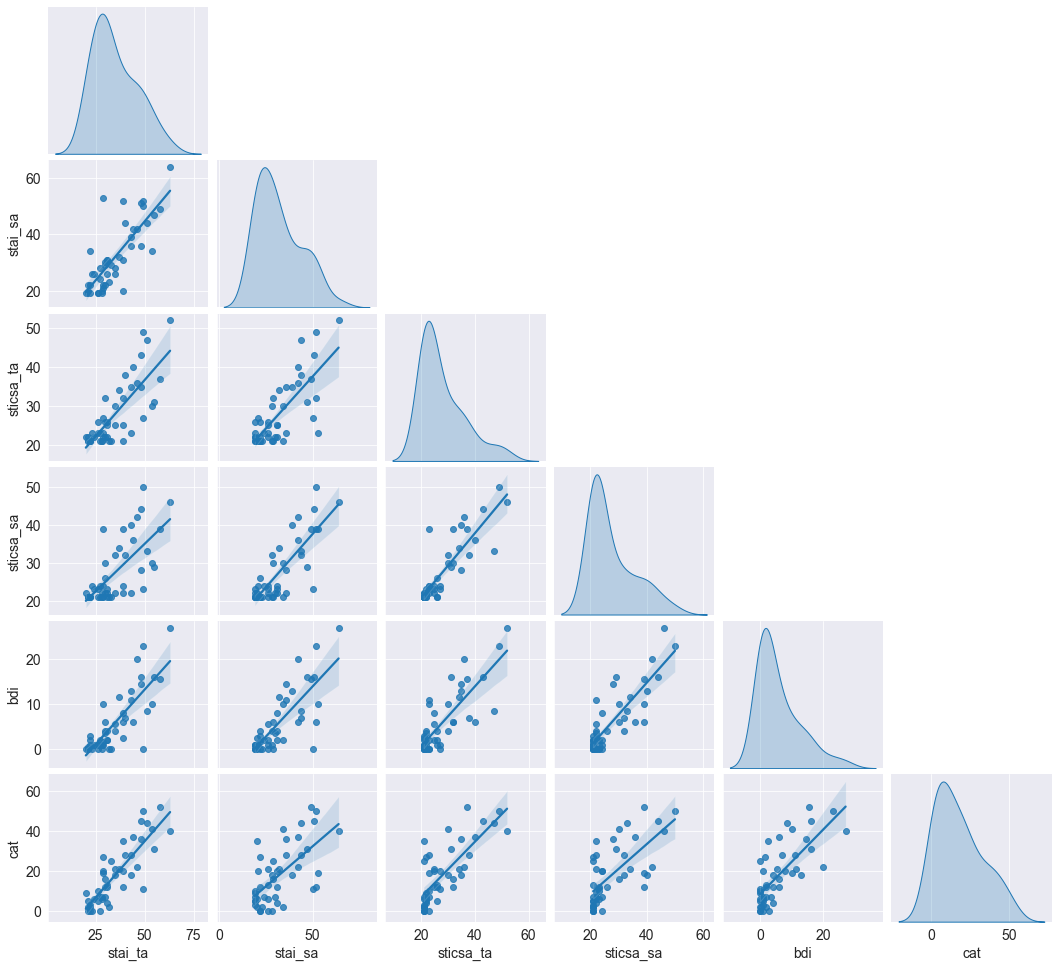

In [11]:
sdf = data.loc[:,["stai_ta", "stai_sa", "sticsa_ta", "sticsa_sa", "bdi", "cat"]]
g = sns.pairplot(sdf, corner=True, diag_kind="kde", kind="reg")
plt.subplots_adjust(top=0.9)

### Cross Correlations

In [12]:
df = data.loc[:,["stai_ta", "stai_sa", "sticsa_ta", "sticsa_sa", "bdi", "cat"]]

In [13]:
from scipy.stats import pearsonr

In [14]:
rho = df.corr()
pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho.round(2).astype(str) + p

stai_ta  stai_sa sticsa_ta sticsa_sa      bdi      cat
stai_ta     1.0***  0.79***   0.79***   0.69***  0.81***  0.85***
stai_sa    0.79***   1.0***   0.76***   0.82***  0.78***  0.64***
sticsa_ta  0.79***  0.76***    1.0***   0.87***  0.81***  0.77***
sticsa_sa  0.69***  0.82***   0.87***    1.0***  0.85***  0.68***
bdi        0.81***  0.78***   0.81***   0.85***   1.0***  0.74***
cat        0.85***  0.64***   0.77***   0.68***  0.74***   1.0***

<AxesSubplot:>

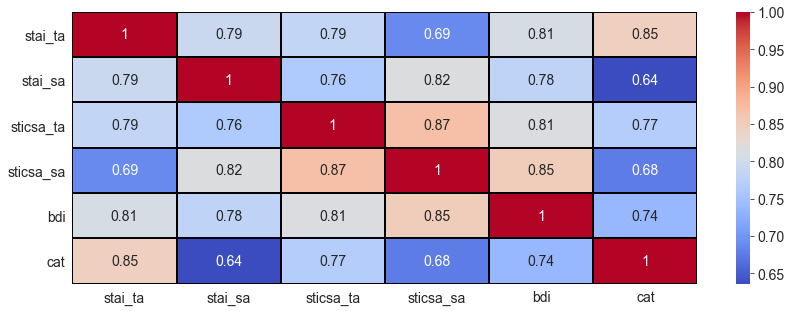

In [15]:
mpl.rcParams['figure.figsize'] = 14,5
mpl.rcParams['font.size'] = 14
sns.heatmap(rho, cmap = 'coolwarm', linecolor = 'black', linewidth = 1, annot = True)

### Summary Table

In [16]:
 import xlsxwriter

In [17]:
dec = 3 #number of decimal points

header = pd.MultiIndex.from_product([['Male','Female'],
                                     ['M', '%', 'SD']])
summary = pd.DataFrame([['',str(round((data['sr_gender'][data['sr_gender'] == 'M'].count() / data['sr_gender'].count()) * 100,2)) + ' %','','',str(round((data['sr_gender'][data['sr_gender'] == 'F'].count() / data['sr_gender'].count()) * 100,2)) + ' %',''],
                   [round(data['sr_age'][data['sr_gender'] == 'M'].mean(),2),'',round(data['sr_age'][data['sr_gender'] == 'M'].std(),2),round(data['sr_age'][data['sr_gender'] == 'F'].mean(),2),'',round(data['sr_age'][data['sr_gender'] == 'F'].std(),2)],
                   [round(data['stai_ta'][data['sr_gender'] == 'M'].mean(),2),'',round(data['stai_ta'][data['sr_gender'] == 'M'].std(),2),round(data['stai_ta'][data['sr_gender'] == 'F'].mean(),2),'',round(data['stai_ta'][data['sr_gender'] == 'F'].std(),2)],
                   [round(data['stai_sa'][data['sr_gender'] == 'M'].mean(),2),'',round(data['stai_sa'][data['sr_gender'] == 'M'].std(),2),round(data['stai_sa'][data['sr_gender'] == 'F'].mean(),2),'',round(data['stai_sa'][data['sr_gender'] == 'F'].std(),2)],
                   [round(data['sticsa_ta'][data['sr_gender'] == 'M'].mean(),2),'',round(data['sticsa_ta'][data['sr_gender'] == 'M'].std(),2),round(data['sticsa_ta'][data['sr_gender'] == 'F'].mean(),2),'',round(data['sticsa_ta'][data['sr_gender'] == 'F'].std(),2)],
                   [round(data['sticsa_sa'][data['sr_gender'] == 'M'].mean(),2),'',round(data['sticsa_sa'][data['sr_gender'] == 'M'].std(),2),round(data['sticsa_sa'][data['sr_gender'] == 'F'].mean(),2),'',round(data['sticsa_sa'][data['sr_gender'] == 'F'].std(),2)],
                   [round(data['bdi'][data['sr_gender'] == 'M'].mean(),2),'',round(data['bdi'][data['sr_gender'] == 'M'].std(),2),round(data['bdi'][data['sr_gender'] == 'F'].mean(),2),'',round(data['bdi'][data['sr_gender'] == 'F'].std(),2)],
                   [round(data['cat'][data['sr_gender'] == 'M'].mean(),2),'',round(data['cat'][data['sr_gender'] == 'M'].std(),2),round(data['cat'][data['sr_gender'] == 'F'].mean(),2),'',round(data['cat'][data['sr_gender'] == 'F'].std(),2)]], 
                  index=['Gender', 'Age', 'Trait Anxiety (STAIT)', 'State Anxiety (STAIS)', 'Trait Cognitive and Somatic Anxiety (STICSAT)', 'State Cognitive and Somatic Anxiety (STICSAS)', 'Beck Depression Inventory (BDI)', 'Catastrophizing'], 
                  columns=header)
header1 = pd.MultiIndex.from_product([[''],
                                     ['P']])
df1 = pd.DataFrame([[''],
                    [round(stats.ttest_ind(data['sr_age'][data['sr_gender'] == 'F'], data['sr_age'][data['sr_gender'] == 'M'])[1], dec)],
                    [round(stats.ttest_ind(data['stai_ta'][data['sr_gender'] == 'F'], data['stai_ta'][data['sr_gender'] == 'M'])[1], dec)],
                    [round(stats.ttest_ind(data['stai_sa'][data['sr_gender'] == 'F'], data['stai_sa'][data['sr_gender'] == 'M'])[1], dec)],
                    [round(stats.ttest_ind(data['sticsa_ta'][data['sr_gender'] == 'F'], data['sticsa_ta'][data['sr_gender'] == 'M'])[1], dec)],
                    [round(stats.ttest_ind(data['sticsa_sa'][data['sr_gender'] == 'F'], data['sticsa_sa'][data['sr_gender'] == 'M'])[1], dec)],
                    [round(stats.ttest_ind(data['bdi'][data['sr_gender'] == 'F'], data['bdi'][data['sr_gender'] == 'M'])[1], dec)],
                    [round(stats.ttest_ind(data['cat'][data['sr_gender'] == 'F'], data['cat'][data['sr_gender'] == 'M'])[1], dec)]],
                   index=['Gender', 'Age', 'Trait Anxiety (STAIT)', 'State Anxiety (STAIS)', 'Trait Cognitive and Somatic Anxiety (STICSAT)', 'State Cognitive and Somatic Anxiety (STICSAS)', 'Beck Depression Inventory (BDI)', 'Catastrophizing'], columns=header1)

visit1_lab_demographics = summary.join(df1)

visit1_lab_demographics.to_excel('output/visit1_lab_demographics.xlsx')


In [17]:
visit1_lab_demographics

Male                 Female  \
                                                   M        %     SD      M   
Gender                                                32.61 %                 
Age                                            28.07            4.43  28.26   
Trait Anxiety (STAIT)                          29.00            9.44  37.84   
State Anxiety (STAIS)                          25.93            9.57  34.94   
Trait Cognitive and Somatic Anxiety (STICSAT)  25.60            8.28  29.10   
State Cognitive and Somatic Anxiety (STICSAS)  24.93            6.57  28.71   
Beck Depression Inventory (BDI)                 2.80            4.31   7.40   
Catastrophizing                                12.87           14.45  20.52   

                                                                      
                                                     %     SD      P  
Gender                                         67.39 %                
Age                                                      5.47  0.907  
Trait Anxiety (STAIT)                                   11.02  0.011  
State Anxiety (STAIS)                                   11.91  0.014  
Trait Cognitive and Somatic Anxiety (STICSAT)            8.19  0.183  
State Cognitive and Somatic Anxiety (STICSAS)            8.62  0.142  
Beck Depression Inventory (BDI)                          7.28  0.029  
Catastrophizing                                         14.61  0.102

#### Response distributions

- histograms/density plots are normalized per category

In [18]:
(sns.color_palette("rocket"))

[(0.20973515, 0.09747934, 0.24238489),
 (0.43860848, 0.12177004, 0.34119475),
 (0.67824099, 0.09192342, 0.3504148),
 (0.8833417, 0.19830556, 0.26014181),
 (0.95381595, 0.46373781, 0.31769923),
 (0.96516917, 0.70776351, 0.5606593)]

STAI trait anxiety
STICSA trait
Age
Media valence
COVID worry
Avoidance behaviour
COVID-spec anxiety
COVID prob estimates


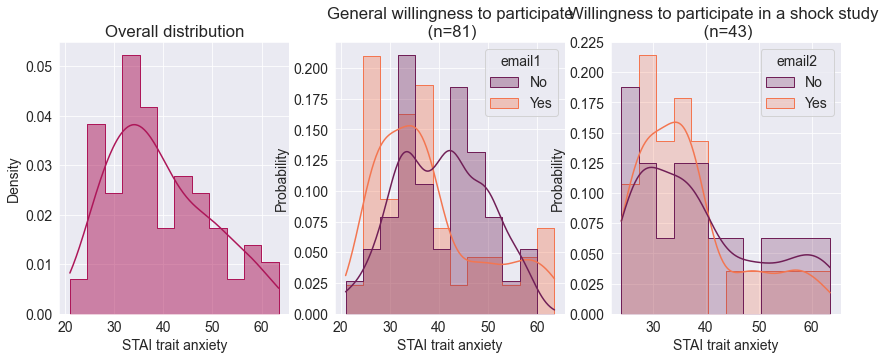

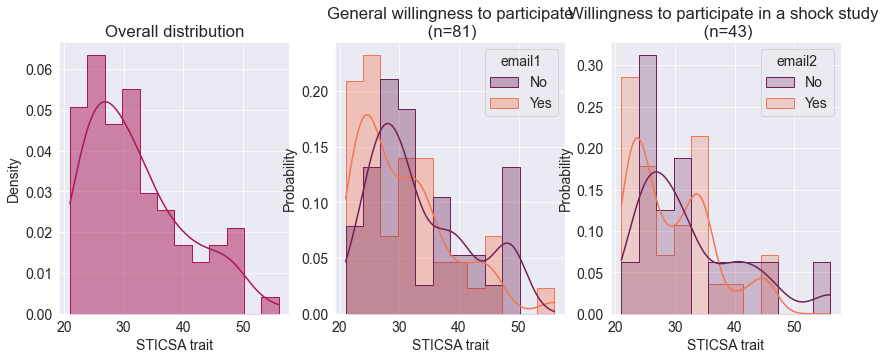

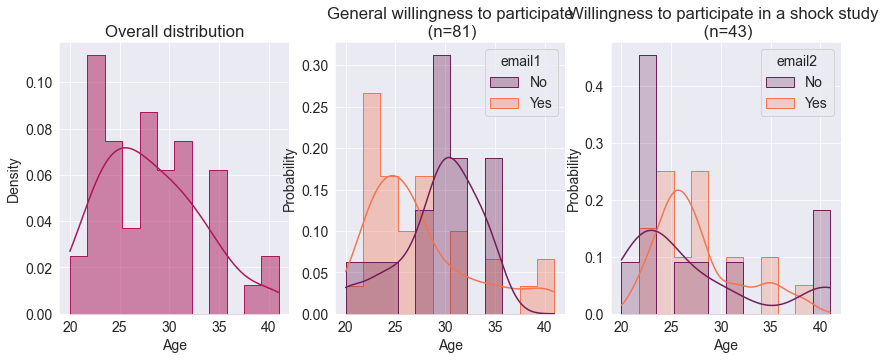

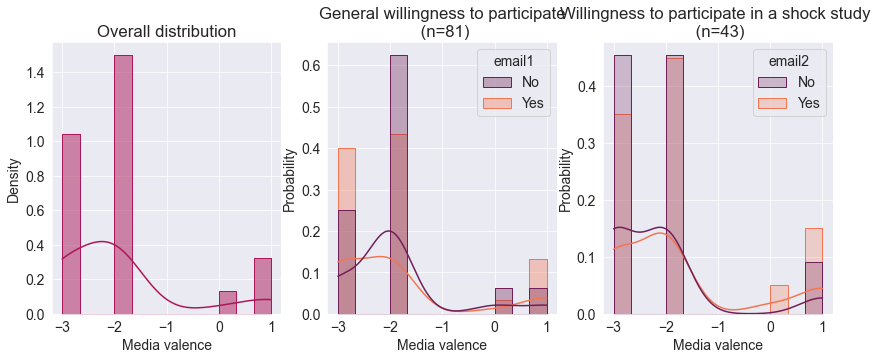

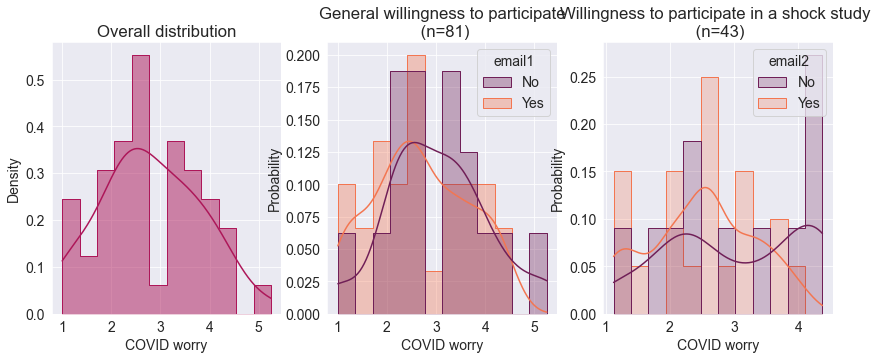

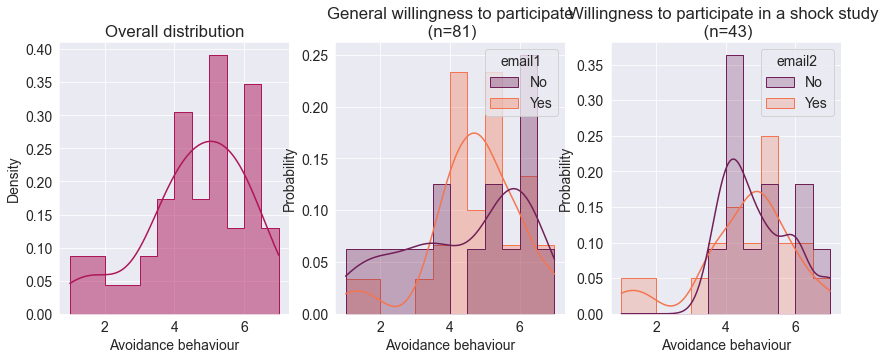

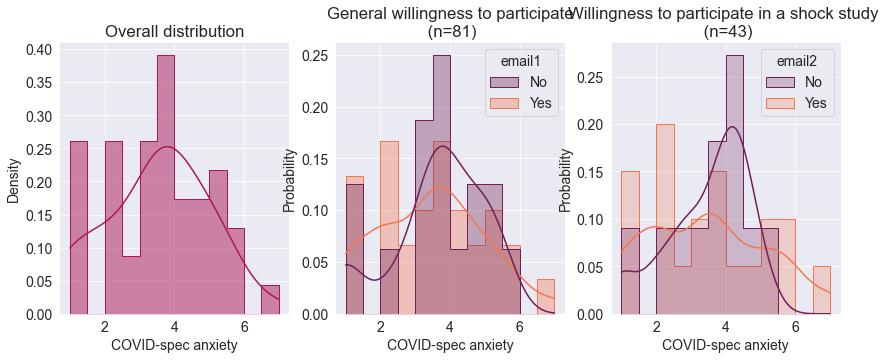

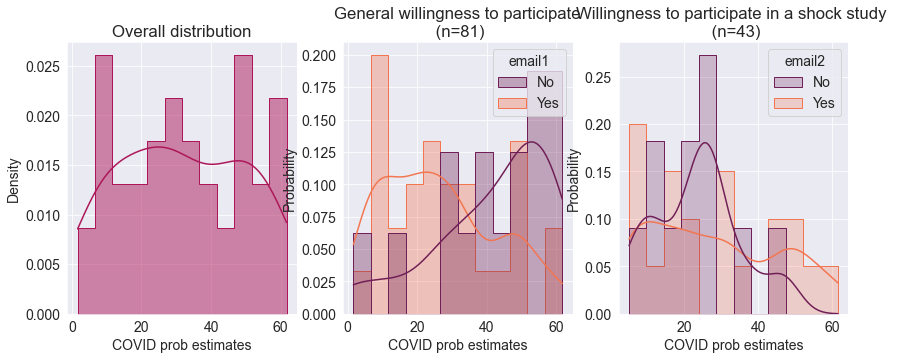

In [19]:
ivs = ['ta_overall', 'stta_overall', 'sr_age',
       'q6_media_valence', 'covid_worry', 'covid_avoidance_beh',
       'covid_spec_anxiety', 'covid_prob_estimates']; 
#ivs = ['ta_overall']
labels = ['STAI trait anxiety', 'STICSA trait', 'Age', 
         'Media valence', 'COVID worry', 'Avoidance behaviour', 
         'COVID-spec anxiety', 'COVID prob estimates']

em2 = data.email1.value_counts()[0]


for (v,l) in zip(ivs, labels):
    print(l)
    fig, axs = plt.subplots(ncols=3, figsize=(14,5))
    sns.histplot(data=data, x=v, bins=12, ax=axs[0], stat='density', kde=True, element="step",
                color=sns.color_palette("rocket")[2])
    axs[0].set_title('Overall distribution')
    axs[0].set_xlabel(l)
    
    sns.histplot(data=data, x=v, bins=12, hue='email1', ax=axs[1], stat='probability', kde=True, 
                 kde_kws=dict(bw_method='scott', bw_adjust=0.7),
                 alpha=0.35, element="step",
                palette=list( sns.color_palette("rocket")[i] for i in [1,4] ), common_norm=False)
    axs[1].set_title('General willingness to participate\n (n=81)')
    axs[1].set_xlabel(l)
        
    
    sns.histplot(data=data, x=v, bins=12, hue='email2', ax=axs[2], stat='probability', kde=True, 
                kde_kws=dict(bw_method='scott', bw_adjust=0.6), element="step",
                palette=list( sns.color_palette("rocket")[i] for i in [1,4] ), common_norm=False)
    axs[2].set_title('Willingness to participate in a shock study \n (n='+str(em2)+')')
    axs[2].set_xlabel(l)
    #sns.regplot(x='value', y='wage', data=df_melt, ax=axs[1])
    #sns.boxplot(x='education',y='wage', data=df_melt, ax=axs[2])


0.12998006207221469
0.09962562419750537
0.07963474708497245
0.6038138770088421
0.29934100790353024
0.764312443116012
0.541082457650242
0.007465338555377086


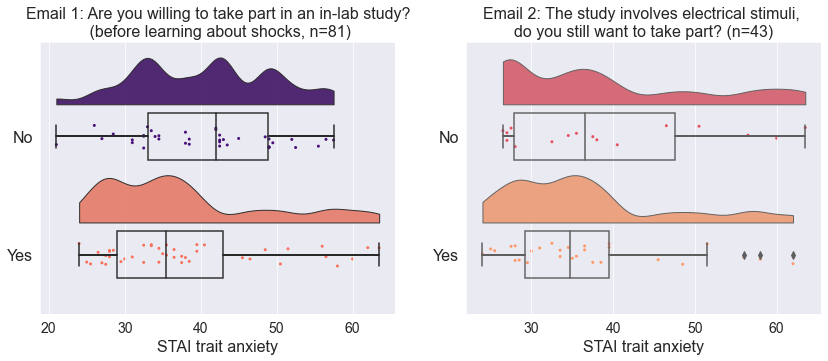

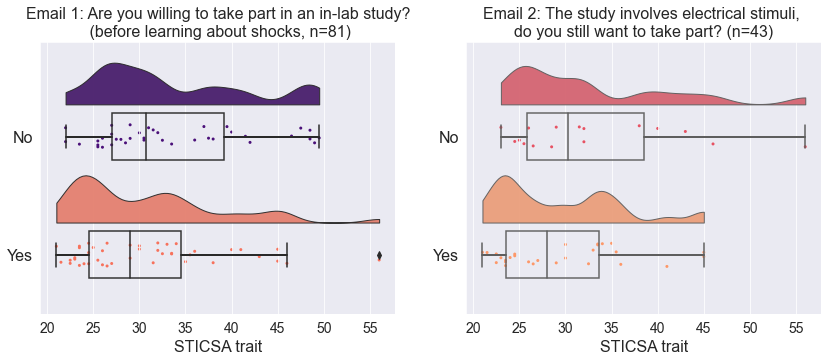

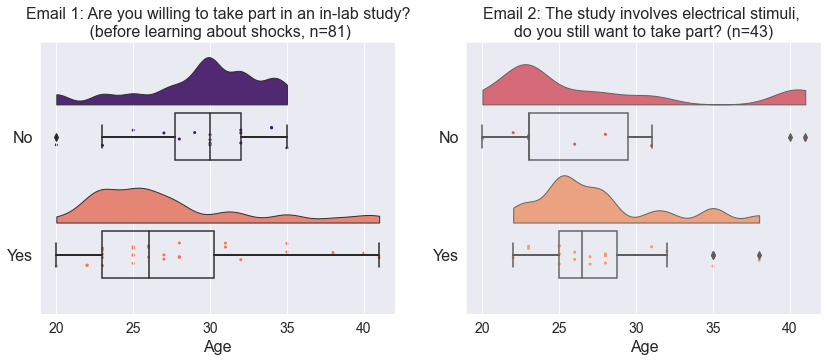

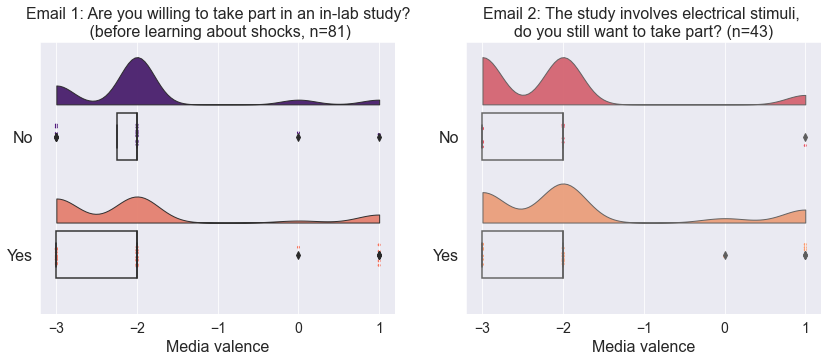

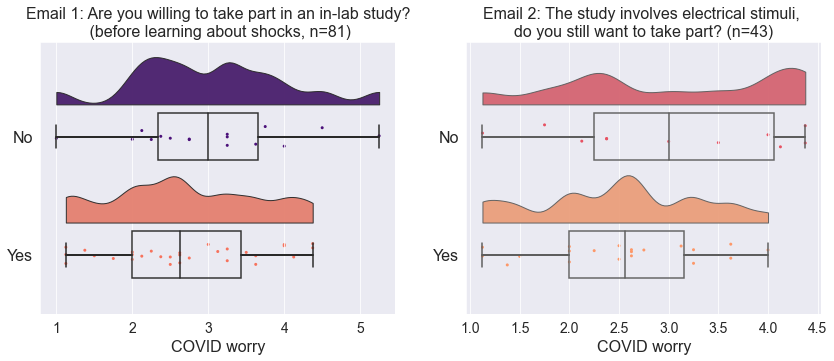

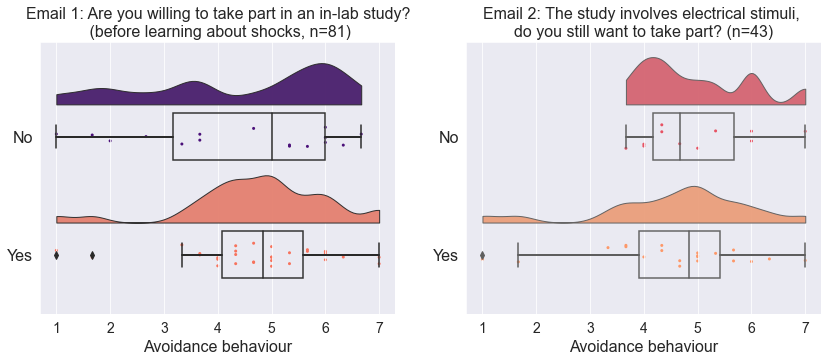

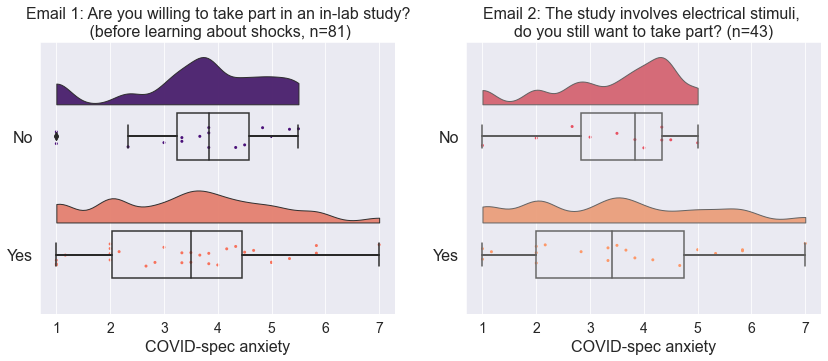

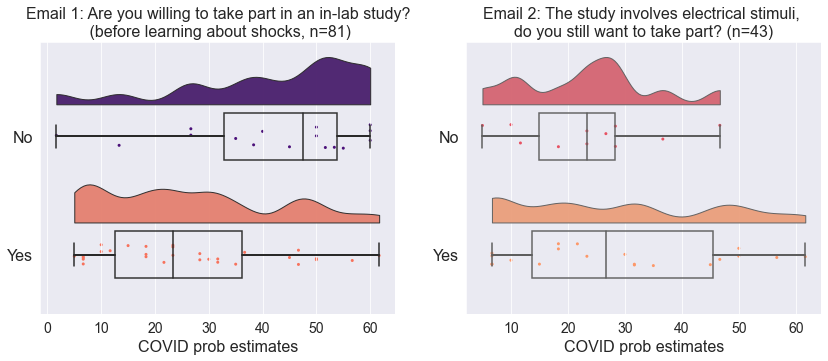

In [23]:
#ivs = ['ta_overall']
#labels=  ['trait anxiety']
cmap = sns.color_palette("magma", as_cmap=True)

for (v,l) in zip(ivs, labels):
    fig, axs = plt.subplots(ncols=2, figsize=(14,5))
    
    td=data.loc[:,data.columns.intersection(["email1", v])].dropna()
    t,p = sp.stats.ranksums(td[v].loc[td.email1=="No"], td[v].loc[td.email1=="Yes"]);
    print(p)
    ax = pt.RainCloud(x = 'email1', y = v, 
                  ax=axs[0],
                  data = data, 
                  width_viol = .8,
                  width_box = .4,
                  orient = 'h',
                  palette=list([cmap(60), cmap(180)] ),
                  alpha=0.95,
                  move = .0)
    axs[0].set_title('Email 1: Are you willing to take part in an in-lab study?\n (before learning about shocks, n=81)',
                    fontsize=16)
    axs[0].set_xlabel(l, fontsize=16)
    axs[0].set_ylabel('')
    axs[0].set_yticklabels(['No', 'Yes'], fontsize=16)
    
    ########
    ax = pt.RainCloud(x = 'email2', y = v, 
                  ax=axs[1],
                  data = data, 
                  width_viol = .8,
                  width_box = .4,
                  orient = 'h',
                  palette=list([cmap(160), cmap(200)] ),
                  alpha=0.95,
                  move = .0)
    axs[1].set_title('Email 2: The study involves electrical stimuli, \ndo you still want to take part? (n='+str(em2)+')',
                     fontsize=16)
    #plt.xticks(np.arange(20,80,10))
    axs[1].set_xlabel(l, fontsize=16)
    axs[1].set_ylabel('')
    axs[1].set_yticklabels(['No', 'Yes'], fontsize=16)
    plt.subplots_adjust(hspace=6)
    plt.savefig('output/figures/selection_bias/'+v+'.pdf') 
    plt.savefig('output/figures/selection_bias/'+v+'.png') 



In [24]:
    sns.histplot(data=data, x=v, bins=12, ax=axs[0], stat='density', kde=True, element="step",
                color=sns.color_palette("rocket")[2])
    axs[0].set_title('Overall distribution')
    axs[0].set_xlabel(l)
    
    sns.histplot(data=data, x=v, bins=12, hue='email1', ax=axs[1], stat='probability', kde=True, 
                 kde_kws=dict(bw_method='scott', bw_adjust=0.7),
                  element="step",
                palette=list( sns.color_palette("rocket")[i] for i in [1,4] ), common_norm=False)
    

<AxesSubplot:title={'center':'Email 2: The study involves electrical stimuli, \ndo you still want to take part? (n=43)'}, xlabel='COVID prob estimates', ylabel='Probability'>